In [21]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainerVTS as TP

In [2]:
import model_v03a1 as mymodel

## Network structures

In [3]:
m1 = mymodel.ImageEncoder()
summary(m1, input_size=(1, 1, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ImageEncoder                             [1, 256]                  --
├─Sequential: 1-1                        [1, 16, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 16, 128, 128]         160
│    └─LeakyReLU: 2-2                    [1, 16, 128, 128]         --
│    └─MaxPool2d: 2-3                    [1, 16, 64, 64]           --
├─Sequential: 1-2                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           4,640
│    └─LeakyReLU: 2-5                    [1, 32, 64, 64]           --
│    └─MaxPool2d: 2-6                    [1, 32, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 16, 16]           --
│    └─Conv2d: 2-7                       [1, 64, 32, 32]           18,496
│    └─LeakyReLU: 2-8                    [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-9                    [1, 64, 16, 16]           --
├─Seque

In [4]:
m2 = mymodel.ImageDecoder()
summary(m2, input_size=(1, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ImageDecoder                             [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 4096]                 1,052,672
│    └─ReLU: 2-2                         [1, 4096]                 --
│    └─Linear: 2-3                       [1, 256]                  1,048,832
│    └─ReLU: 2-4                         [1, 256]                  --
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─ConvTranspose2d: 2-5              [1, 64, 32, 32]           1,088
│    └─LeakyReLU: 2-6                    [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 32, 64, 64]           --
│    └─ConvTranspose2d: 2-7              [1, 32, 64, 64]           32,800
│    └─LeakyReLU: 2-8                    [1, 32, 64, 64]           --
├─Sequential: 1-4                        [1, 1, 128, 128]       

In [5]:
m3 = mymodel.CsiEncoder()
summary(m3, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
CsiEncoder                               [1, 256]                  353,374,464
├─Sequential: 1-1                        [1, 16, 30, 98]           --
│    └─Conv2d: 2-1                       [1, 16, 30, 98]           160
│    └─LeakyReLU: 2-2                    [1, 16, 30, 98]           --
├─Sequential: 1-2                        [1, 32, 14, 48]           --
│    └─Conv2d: 2-3                       [1, 32, 14, 48]           4,640
│    └─LeakyReLU: 2-4                    [1, 32, 14, 48]           --
├─Sequential: 1-3                        [1, 64, 12, 46]           --
│    └─Conv2d: 2-5                       [1, 64, 12, 46]           18,496
│    └─LeakyReLU: 2-6                    [1, 64, 12, 46]           --
├─Sequential: 1-4                        [1, 128, 10, 44]          --
│    └─Conv2d: 2-7                       [1, 128, 10, 44]          73,856
│    └─LeakyReLU: 2-8                    [1, 128, 10, 44]       

## Loader

In [3]:
datadir = '../Dataset/0307make06/'
print(os.listdir(datadir))

['csi.npy', 'img.npy']


In [4]:
mydata = TP.MyDataset(datadir + 'csi.npy', datadir + 'img.npy')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.004)
valid_size = int(len(mydata) * 0.004)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 8)

loaded
(7638, 2, 90, 100) (7638, 1, 128, 128)
30 30 7578
30 30 7578


In [5]:
# Hyperparameters
t_args = TP.MyArgs(cuda=1, epochs=1000, learning_rate=1e-4, criterion=nn.SmoothL1Loss())
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-5, criterion=nn.SmoothL1Loss())

In [6]:
# Model and Loss
imgencoder = mymodel.ImageEncoder(batchnorm=True, latent_dim=512).to(t_args.device)
imgdecoder = mymodel.ImageDecoder(latent_dim=512, normalized=False).to(t_args.device)
csiencoder = mymodel.CsiEncoder(batchnorm=False, latent_dim=512).to(t_args.device)
optimizer = torch.optim.Adam

trainer = TP.TrainerVariationalTS(img_encoder=imgencoder, img_decoder=imgdecoder, csi_encoder=csiencoder,
                                   teacher_args=t_args, student_args=s_args, 
                                   train_loader=train_loader, valid_loader=valid_loader, test_loader=test_loader,
                                   optimizer=optimizer, temperature=1, latent_dim=512)

# Load from checkpoints
trainer.toal_epochs=0
imgencoder.load_state_dict(torch.load('../Models/ImgEn_Model_v02a1_ImgEn_Fc_0307_tep1200.pth'))
imgdecoder.load_state_dict(torch.load('../Models/ImgDe_Model_v02a1_ImgDe_FC_0307_tep1200.pth'))
csiencoder.load_state_dict(torch.load('../Models/CSIEn_Model_v02a1_CsiEn_Last_0307_tep1200_sep700.pth'))

In [14]:
# When changing learning rate
t_args = TP.MyArgs(cuda=1, epochs=1000, learning_rate=1e-5, criterion=nn.SmoothL1Loss())
s_args = TP.MyArgs(cuda=1, epochs=100, learning_rate=1e-7, criterion=nn.SmoothL1Loss())
trainer.teacher_args = t_args
trainer.student_args = s_args

In [15]:
# Training and Saving
trainer.train_teacher()

Teacher: epoch=999/1000,2/3of train, loss=148.50308227539062
Total training time: 64.56917190551758 sec


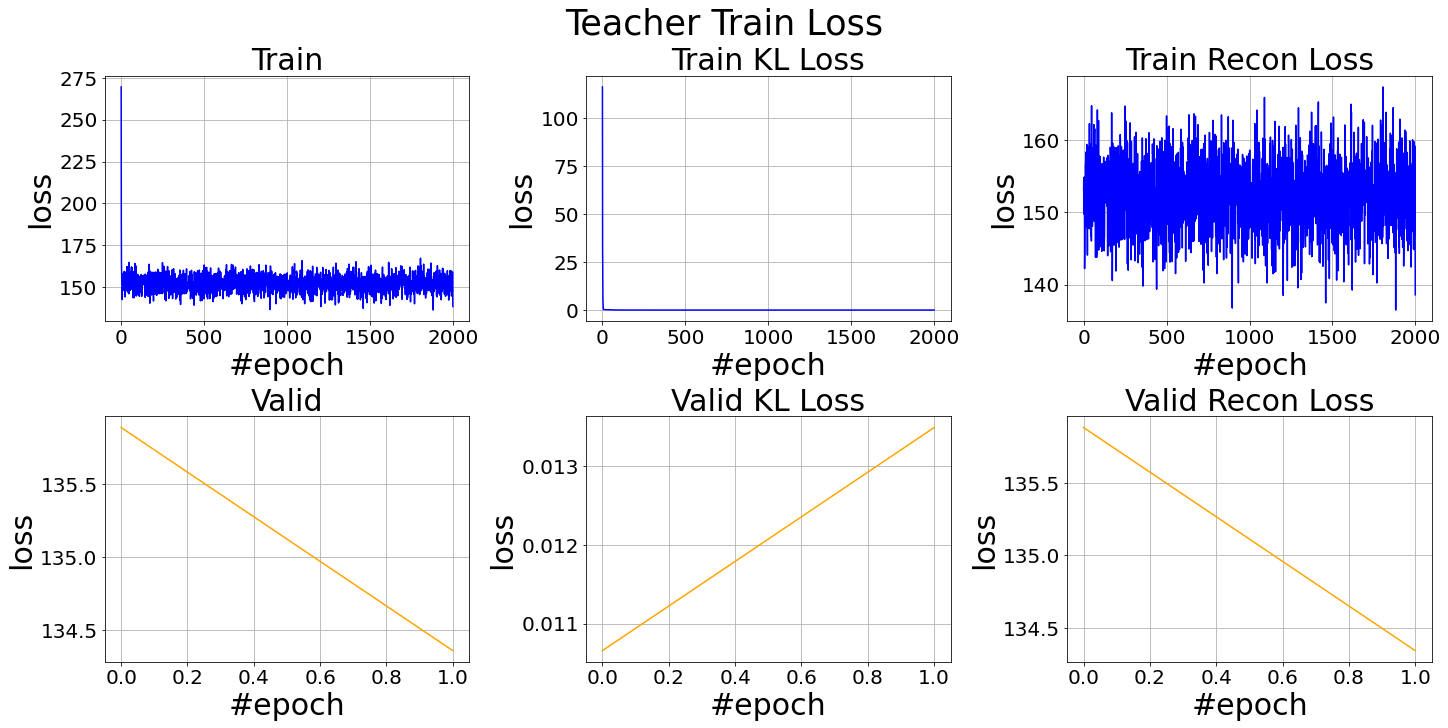

In [16]:
# Plot loss curves
%matplotlib inline
trainer.plot_teacher_loss()

In [17]:
  #=====================test============================
trainer.test_teacher(mode='train')

Teacher: 0/3of test, loss=237.51382446289062

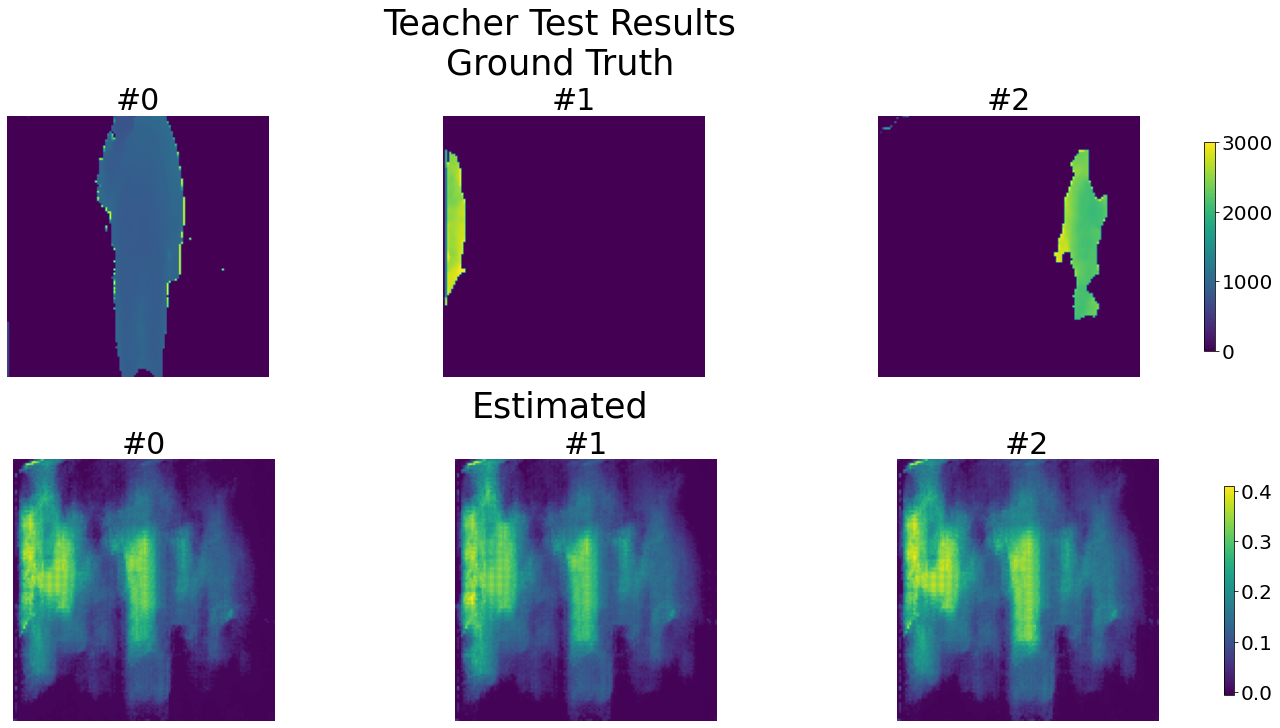

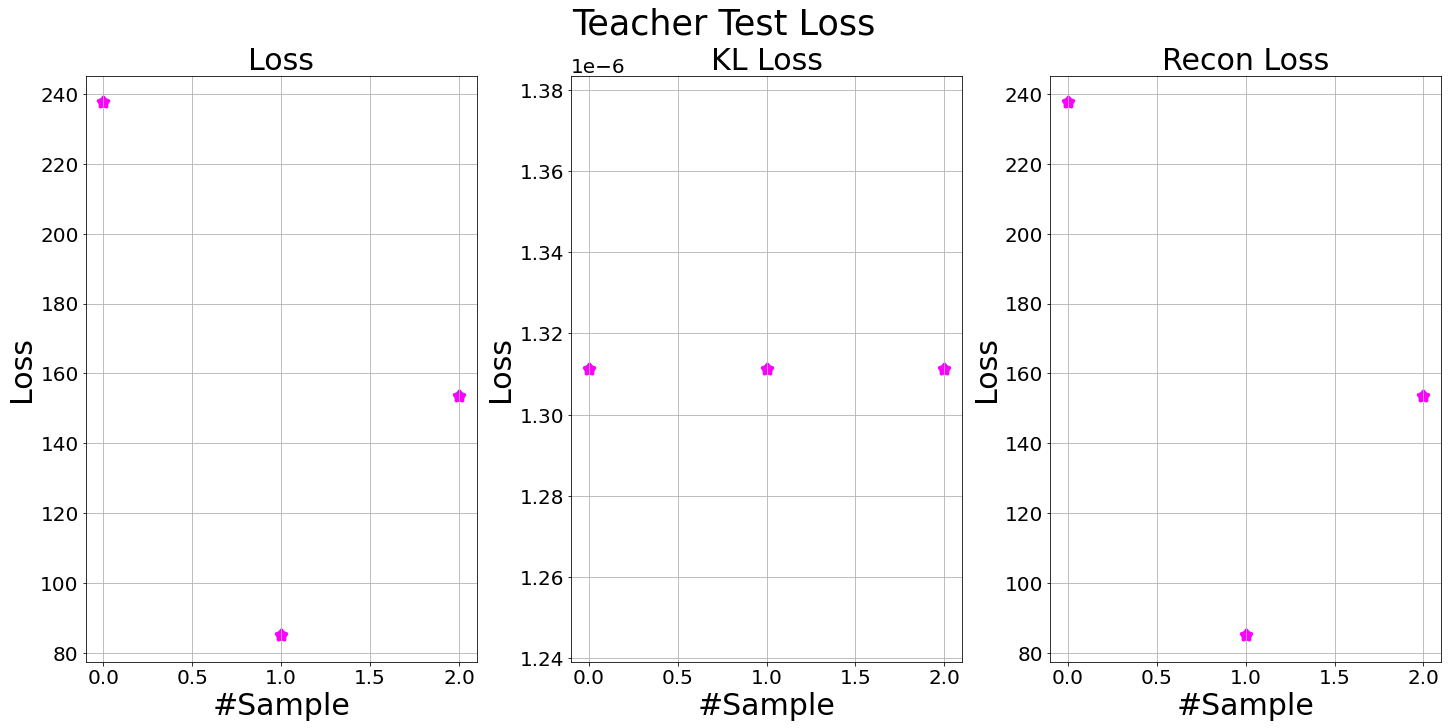

In [19]:
%matplotlib inline
trainer.plot_teacher_test(select_num=3)

# Training and Saving
trainer.train_student()

In [ ]:
# Plot loss curves
%matplotlib inline
trainer.plot_student_loss()

In [ ]:
  #=====================test============================
trainer.test_student()

In [ ]:
# Final outputs
%matplotlib inline
trainer.plot_student_test()

In [33]:
notion = '_0307'
torch.save(trainer.csi_encoder.state_dict(),
           '../Models/CSIEn_' + str(trainer.csi_encoder) + notion + '_tep' + str(trainer.teacher_epochs) +
           '_sep' + str(trainer.student_epochs) + '.pth')